In [180]:
import pandas as pd
import holidays

In [24]:
from xlsx2csv import Xlsx2csv

In [25]:
Xlsx2csv("../data/CounterData_Nuuksio and Pallas-Ylläs.xlsx", outputencoding="utf-8").convert("myfile.csv")

In [134]:
df = pd.read_csv('myfile.csv')

In [163]:
df['StartTime'] = pd.to_datetime(df['StartTime'])
df['EndTime'] = pd.to_datetime(df['EndTime'])

In [35]:
df['time_diff'] = df['EndTime'] - df['StartTime']

In [37]:
import datetime

In [50]:
df.reset_index(inplace=True, drop=True)

In [52]:
from pyproj import Proj, transform

In [80]:
x, y = 377533.0, 7550971.0

In [84]:
in1 = Proj(init='epsg:3067')
out1 = Proj(init='epsg:4326')

y2,x2 = transform(in1, out1, x, y)
print(x2,y2)

68.04659828968704 24.0636735398413


In [114]:
df['North_East'] = df['PAVE_Counters.CoordinateNorth'].astype('str') + ' ' + df['PAVE_Counters.CoordinateEast'].astype('str')

In [118]:
coordinates = df['North_East'].unique().tolist()

In [120]:
def f(y1, x1):
    in1 = Proj(init='epsg:3067')
    out1 = Proj(init='epsg:4326')
    
    y2, x2 = transform(in1, out1, x1, y1)
    return x2, y2


all_row = []
columns = ['North', 'East', 'Lat', 'Lon']
for cords in coordinates:
    n = cords.split()[0]
    e = cords.split()[1]
    
    lat, lon = f(n, e)
    row = [n, e, lat, lon]
    
    all_row.append(row)

df = pd.DataFrame(all_row, columns=columns)    

In [129]:
import numpy as np
df.replace('nan', np.nan, inplace=True)

In [131]:
df.dropna(axis=0, how='any', inplace=True)

In [133]:
df_cords = df.copy()

In [140]:
df_cords['North'] = df_cords['North'].astype('float')
df_cords['East'] = df_cords['East'].astype('float')

In [141]:
df_joined = pd.merge(left=df, right=df_cords, left_on=['PAVE_Counters.CoordinateNorth', 'PAVE_Counters.CoordinateEast'], right_on=['North', 'East'])

In [142]:
df_joined.shape

(565341, 23)

In [144]:
import matplotlib.pyplot as plt

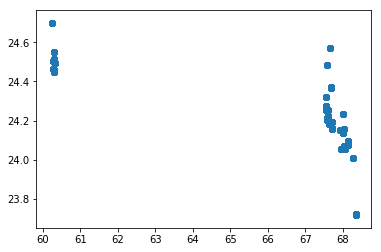

In [147]:
plt.scatter(df_joined['Lat'], df_joined['Lon'])

In [148]:
plt.show()

In [149]:
from sklearn.cluster import KMeans

In [150]:
model = KMeans(n_clusters=3)

In [151]:
model.fit(df_joined[['Lat', 'Lon']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [152]:
df_joined['cluster_id'] = model.predict(df_joined[['Lat', 'Lon']])

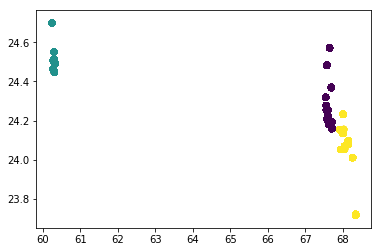

In [155]:
plt.scatter(df_joined['Lat'], df_joined['Lon'], c=df_joined['cluster_id'])

In [156]:
plt.show()

In [157]:
model.cluster_centers_

array([[67.60405171, 24.24368706],
       [60.30442087, 24.49646922],
       [68.10265115, 24.01885602]])

In [158]:
cluster_centers = {0: [67.60405171, 24.24368706], 1: [60.30442087, 24.49646922], 2: [68.10265115, 24.01885602]}

In [160]:
df_weather_0 = pd.read_csv('./cluster_0_weather.csv')

In [165]:
df_joined.to_csv('Cords_and_Cluster.csv', index=False)

### Using numbers generated CSV

In [213]:
df_new = pd.read_csv('../data/zamzar_exported.csv', sep=',')

In [220]:
df_new['PAVE_Counters.CoordinateNorth'].replace('nan', np.nan, inplace=True)
df_new['PAVE_Counters.CoordinateEast'].replace('nan', np.nan, inplace=True)

In [222]:
df_new.isnull().sum()

CounterReadingID                      0
CounterID_ASTA                        0
SequenceNumber                        0
StartTime                             0
EndTime                               0
Visits                                0
ASTA_Counters.CounterID_PAVE         16
ASTA_Counters.Name_ASTA               0
ASTA_Counters.InstallationDate       76
ASTA_Counters.NationalParkCode        0
ASTA_Counters.Municipality            0
ASTA_Counters.RegionalUnit            0
ASTA_Counters.RegionalEntity         10
PAVE_Counters.Globalid              217
PAVE_Counters.Name                  217
PAVE_Counters.Manager               332
PAVE_Counters.AdditionalInfo      84759
PAVE_Counters.CoordinateNorth       217
PAVE_Counters.CoordinateEast        217
dtype: int64

In [217]:
df_joined.shape

(565341, 24)

In [225]:
df_new.dropna(axis='index', subset=['PAVE_Counters.CoordinateEast', 'PAVE_Counters.CoordinateNorth'], inplace=True)

In [226]:
df_new.shape

(565341, 19)

In [227]:
df_new['cluster_id'] = model.labels_

In [230]:
df_new['StartTime'] = pd.to_datetime(df_new['StartTime'])
df_new['EndTime'] = pd.to_datetime(df_new['EndTime'])

In [231]:
df_new['StartTime'].dt.hour.unique()

array([15, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7, 16, 18,  8,
       17,  9, 12, 13, 14, 10, 11])

In [232]:
df_new['time_diff'] = df_new['EndTime'] - df_new['StartTime']

In [234]:
df_201705 = df_new[df_new['StartTime'] >= datetime.datetime(2017,5,1)].copy()

In [236]:
df_201705.shape

(358362, 21)

In [237]:
df_201705 = df_201705[df_201705['time_diff'] == datetime.timedelta(hours=1)]

In [238]:
df_201705['time_diff'].value_counts()

01:00:00    357781
Name: time_diff, dtype: int64

### JOIN weather data

In [263]:
weather_0 = pd.read_csv('cluster_0_weather.csv')
weather_1 = pd.read_csv('cluster_1_weather.csv')
weather_2 = pd.read_csv('cluster_2_weather.csv')

In [264]:
weather = pd.concat([weather_0, weather_1, weather_2])

In [267]:
weather.head(2)

,time,precip_intensity,precip_type,precip_probability,temperature,humidity,wind_speed,wind_gust,cloud_cover,visibility,cluster_id
0,2019-10-10 00:00:00,0.0333,rain,0.10,3.82,0.73,2.43,4.14,1.0,10.054,0
1,2019-10-10 01:00:00,0.0365,rain,0.09,2.65,0.73,2.99,3.45,1.0,10.121,0


In [266]:
weather['time'] = weather['time'].str[:-6]

In [268]:
weather['time'] = pd.to_datetime(weather['time'])

In [269]:
weather.dtypes

time                  datetime64[ns]
precip_intensity             float64
precip_type                   object
precip_probability           float64
temperature                  float64
humidity                     float64
wind_speed                   float64
wind_gust                    float64
cloud_cover                  float64
visibility                   float64
cluster_id                     int64
dtype: object

In [242]:
df_201705.shape

(357781, 21)

In [270]:
df_jo = pd.merge(left=df_201705, right=weather, left_on=['StartTime', 'cluster_id'], right_on=['time', 'cluster_id'])

In [271]:
df_jo.shape

(357071, 31)

In [273]:
df_jo.to_csv('good_data_with_weather.csv', index=False)

### Adding Holiday Code

In [278]:
df_jo['is_holiday'] = df_jo['StartTime'].apply(isHoliday)
df_jo['weekDayNumber'] = df_jo['StartTime'].apply(weekdayNumber)
df_jo['is_weekend'] = df_jo['StartTime'].apply(isWeekend)
df_jo['berry_season'] = df_jo['StartTime'].apply(isBerrySeason)
df_jo['mushroom_season'] = df_jo['StartTime'].apply(isMushroomSeason)

In [277]:
df_jo['school_season'] = df_jo['StartTime'].apply(isSchoolSeason)

In [276]:
import holidays
from datetime import date
from datetime import datetime

fin_holidays = holidays.Finland()

def isHoliday(startTime):
    return startTime.date() in fin_holidays

def weekdayNumber(startTime):
    return startTime.weekday()

def isWeekend(startTime):
    if weekdayNumber(startTime) < 5:
        return False
    return True

def isBerrySeason(startTime):
    if (startTime.month > 7 and startTime.month < 10) or (startTime.month is 7 and startTime.day > 15):
            return True
    return False

def isMushroomSeason(startTime):
    if (startTime.month > 5 and startTime.month < 10) or (startTime.month is 5 and startTime.day > 15):
            return True
    return False

def isSchoolSeason(startTime):
    if startTime.date().year == 2017:
        if date(2017,5,2)<= startTime.date() <= date(2017,5,24):
            return True
        if date(2017,5,29) <= startTime.date() <= date(2017,6,1):
            return True
        if date(2017, 8, 14)<= startTime.date() <= date(2017,10,13):
            return True
        if date(2017, 10, 23) <= startTime.date() <= date(2017,12,22):
            return True
    if startTime.date().year == 2018:
        if date(2018,1,8) <= startTime.date() <= date(2018,2,16):
             return True
        if date(2018,2,26) <= startTime.date() <= date(2018, 3, 28):
            return True
        if date(2018, 4,3) <= startTime.date() <= date(2018, 4, 27):
            return True
        if date(2018, 5, 2) <= startTime.date() <= date(2018, 5, 9):
            return True
        if date(2018, 5, 14) <= startTime.date() <= date(2018, 5, 31):
            return True
        if date(2018, 8, 9) <= startTime.date() <= date(2018, 10, 12):
            return True
        if date(2018, 10, 22) <= startTime.date() <= date(2018, 12, 21):
            return True
    if startTime.date().year == 2019:
        if date(2019, 1, 7) <= startTime.date() <= date(2019, 2, 15):
            return True
        if date(2019, 2, 25) <= startTime.date() <= date(2019, 4, 18):
            return True
        if startTime.date() is not date(2019,5,1):
            return True
        if date(2019, 4, 23) <= startTime.date() <= date(2019, 5, 29):
            return True
        if date(2019, 8, 8) <= startTime.date() <= date(2019, 10, 11):
            return True
        if date(2019, 10, 21) <= startTime.date() <= date(2019, 12, 20):
            return True
    if startTime.date().year == 2020:
        if date(2020, 1, 7) <= startTime.date() <= date(2020, 2, 14):
            return True
        if date(2020, 2, 24) <= startTime.date() <= date(2020, 5, 29):
            return True
    return False

isHoliday(datetime.strptime("2004.12.24 17:30", "%Y.%m.%d %H:%M"))

True

In [280]:
df_jo.head(3)

,CounterReadingID,CounterID_ASTA,SequenceNumber,StartTime,EndTime,Visits,ASTA_Counters.CounterID_PAVE,ASTA_Counters.Name_ASTA,ASTA_Counters.InstallationDate,ASTA_Counters.NationalParkCode,...,wind_speed,wind_gust,cloud_cover,visibility,is_holiday,weekDayNumber,is_weekend,berry_season,mushroom_season,school_season
0,1663271,1099,16656,2017-06-13 12:00:00,2017-06-13 13:00:00,0,190927.0,Varkaankuru 2013,7/12/2013 0:00,34361,...,3.05,NaN,0.18,10.003,False,1,False,False,True,False
1,1662793,1139,2683,2017-06-13 12:00:00,2017-06-13 13:00:00,0,190693.0,Tuomikuru,7/16/2014 0:00,34361,...,3.05,NaN,0.18,10.003,False,1,False,False,True,False
2,1635880,1098,37641,2017-06-13 12:00:00,2017-06-13 13:00:00,0,78755.0,Kahvikeidas 2013,2/1/2013 0:00,34361,...,3.05,NaN,0.18,10.003,False,1,False,False,True,False


In [281]:
df_jo.to_csv('data_weather_holiday.csv', index=False)

In [283]:
asd = pd.DataFrame([[1,2], [3,4]], columns =['A', 'B'])

In [284]:
asd

,A,B
0,1,2
1,3,4


In [285]:
asd['C'] = 0
asd['D'] = 0

In [286]:
def fv(x):
    return 1, 2

In [287]:
asd[['C', 'D']] = asd.apply(fv ,axis=1)

In [288]:
asd

,A,B,C,D
0,1,2,1,1
1,3,4,2,2


### Merge daylight data

In [290]:
import datetime
from astral import Astral, Location, AstralError
from dateutil.parser import parse
from pytz import timezone

In [291]:
a = Astral()

pallas = Location()
pallas.name = 'pallas'
pallas.region = 'region'
pallas.latitude = 68.158889
pallas.longitude = 24.040278
pallas.timezone = 'EET'
pallas.elevation = 500

In [292]:
nuuksio = Location()
nuuksio.name = 'nuuksio'
nuuksio.region = 'region'
nuuksio.latitude = 60.307500
nuuksio.longitude = 24.499167
nuuksio.timezone = 'EET'
nuuksio.elevation = 500

locations = {
    852: pallas,
    34361: nuuksio
}

In [323]:
def sun_data(date_, loc):
    try:
        # d = parse(date_)
        d = date_.replace(tzinfo=timezone('EET'))
        sn = locations[loc].sun(d)
        sn_hours = (sn['sunset']-sn['sunrise']).total_seconds()/3600
        sn_current = ((d - sn['sunrise']).total_seconds() > 0 and (d - sn['sunset']).total_seconds() < 0) * 1
        return str(sn_hours), str(sn_current)
    except Exception as e:
        return 0, 0

In [330]:
def sn_hours(x):
    try:
        date1 = x['StartTime']
        code = x['ASTA_Counters.NationalParkCode']

        d = date1.replace(tzinfo=timezone('EET'))
        sn = locations[code].sun(date1)
        sn_hours = (sn['sunset']-sn['sunrise']).total_seconds()/3600
        return sn_hours
    except Exception as e:
        return 0

def lighty(x):
    date1 = x['StartTime']
    code = x['ASTA_Counters.NationalParkCode']
    d = date1.replace(tzinfo=timezone('EET'))
    sn_current = ((d - sn['sunrise']).total_seconds() > 0 and (d - sn['sunset']).total_seconds() < 0) * 1
    return sn_current
    

In [331]:
df_jo['sn_hours'] = 0
df_jo['is_lighty'] = 0

In [332]:
df_jo['sn_hours'] = df_jo.apply(sn_hours, axis=1)

In [325]:
df_jo['ASTA_Counters.NationalParkCode'].unique()

array([34361,   852])

In [326]:
df_jo[['sn_hours', 'is_lighty']] = df_jo.apply(lambda x: sun_data(x['StartTime'], x['ASTA_Counters.NationalParkCode']), axis=1)

ValueError: Must have equal len keys and value when setting with an iterable

In [314]:
sun_data(datetime.datetime(2019,1,1), 34361)

(6.0744444444444445, 0)

In [306]:
a = datetime.datetime(2019,1,1, )

In [310]:
a.tzinfo = 'EET'

AttributeError: attribute 'tzinfo' of 'datetime.datetime' objects is not writable